Index(['CustomerID', 'CustomerName', 'SignupDate', 'TotalValue', 'Quantity',
       'Region_Europe', 'Region_North America', 'Region_South America'],
      dtype='object')


c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Optimal Number of Clusters: 9


c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jigya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 0.614
Silhouette Score: 0.526


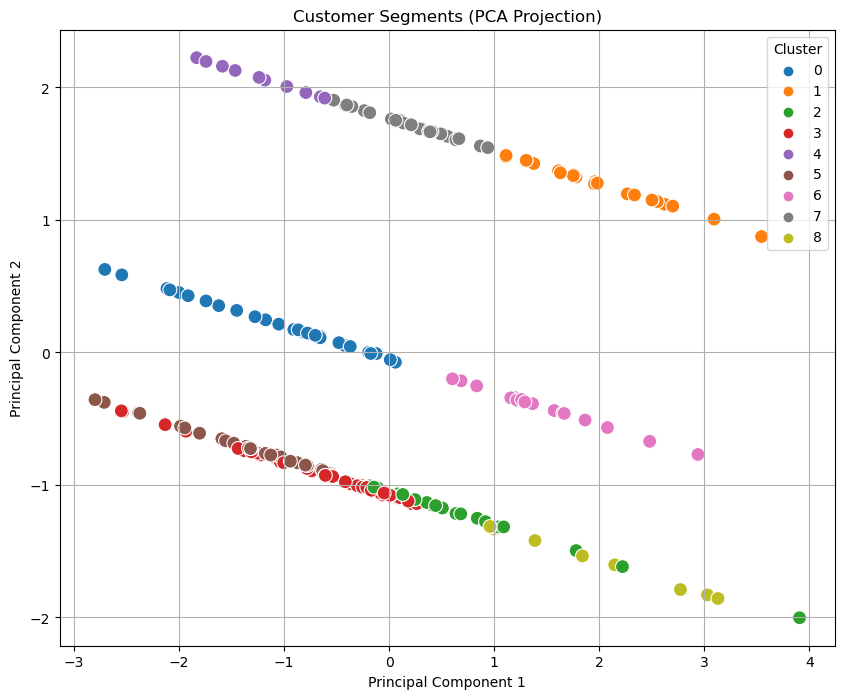

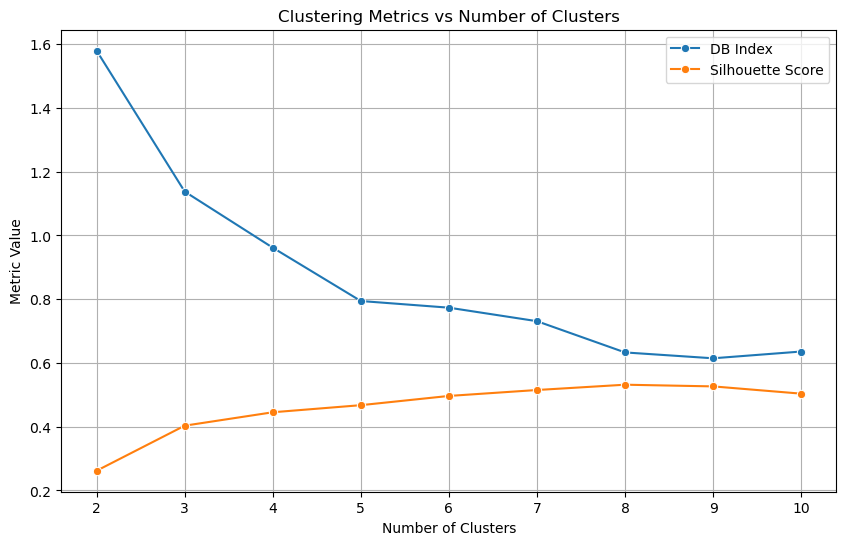

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_file = 'Customers.csv'
transactions_file = 'Transactions.csv'

customers_df = pd.read_csv(customers_file)
transactions_df = pd.read_csv(transactions_file)

# Merge and preprocess data
transactions_agg = transactions_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum'     # Total quantity purchased
}).reset_index()

customers_combined = customers_df.merge(transactions_agg, on='CustomerID', how='left')
customers_combined.fillna({'TotalValue': 0, 'Quantity': 0}, inplace=True)

# Encode categorical data (Region)
customers_combined = pd.get_dummies(customers_combined, columns=['Region'], drop_first=True)

# Prepare features for clustering
print(customers_combined.columns)

# Exclude non-numeric columns such as 'CustomerID', 'SignupDate', and other text-based columns
features = customers_combined.drop(
    columns=[col for col in ['CustomerID', 'SignupDate', 'Name'] if col in customers_combined.columns],
    errors='ignore'
)
# Drop unnecessary columns if they exist
features = customers_combined.drop(columns=['CustomerID', 'SignupDate'], errors='ignore')

# Ensure all features are numeric
features = features.select_dtypes(include=[np.number])

# Standardize numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Perform clustering with K-Means for different numbers of clusters
metrics = []
clusters_range = range(2, 11)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)
    metrics.append((k, db_index, silhouette_avg))

# Select the optimal number of clusters based on DB Index
optimal_k = min(metrics, key=lambda x: x[1])[0]
print(f"Optimal Number of Clusters: {optimal_k}")

# Final clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
customers_combined['Cluster'] = kmeans.labels_

# Evaluate final clustering
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customers_combined['PCA1'] = pca_features[:, 0]
customers_combined['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customers_combined, palette='tab10', s=100
)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid()
plt.show()

# Save clustering results
customers_combined.to_csv('Customer_Segments.csv', index=False)

# Visualize metrics
metrics_df = pd.DataFrame(metrics, columns=['Clusters', 'DB Index', 'Silhouette Score'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x='Clusters', y='DB Index', marker='o', label='DB Index')
sns.lineplot(data=metrics_df, x='Clusters', y='Silhouette Score', marker='o', label='Silhouette Score')
plt.title('Clustering Metrics vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Value')
plt.legend()
plt.grid()
plt.show()
